## Experimentation with Different Models
#### *(Still in Progress)*

## 1. Data Label Fromat

#### 1.1. Original Annotation Format to KITTI Format

The filtermoosekitti.py script, sourced from the asvath/cadcd repository, plays a crucial role in ensuring the integrity and standardization of our dataset annotations. Developed by the original author, this script filters annotations based on a minimum of 20 lidar points, effectively eliminating potential noise or outliers from the ground truth data. This methodical approach not only aligns annotations with the KITTI format but also incorporates essential details such as truncation, observation angle, and pixel coordinates. The script's commitment to maintaining a standardized layout enhances the overall robustness of the dataset, making it well-suited for experimentation with various object detection models. For further reference, you can find the script in the asvath/cadcd repository.

In [89]:
import os

# Define the parent directory where the 'image_00', 'image_01', ..., 'image_07' folders are located
parent_directory = 'C:\\Users\\rafae\\Documents\\Capstone\\autonomoose\\processedmoose'  

# Loop through each subfolder (image_00, image_01, ..., image_07)
for i in range(8):
    subfolder_name = 'image_{:02d}'.format(i)
    subfolder_path = os.path.join(parent_directory, subfolder_name, 'data') 

    # Loop through each image in the subfolder
    for j in range(100):
        old_image_name = '000000{:04d}.png'.format(j)
        new_image_name = '000000{:04d}.png'.format(i * 100 + j)

        old_image_path = os.path.join(subfolder_path, old_image_name)
        new_image_path = os.path.join(subfolder_path, new_image_name)

        # Rename the image
        os.rename(old_image_path, new_image_path)


Great, we have remaned all images in the folers image_##: {old_image_name} -> {new_image_name}
    
Image_00 > 0000000002.png -> 0000000002.png, ..., 00000000099.png -> 00000000099.png
    
Image_01 > 0000000002.png -> 0000000102.png, ..., 00000000099.png -> 00000000199.png
    
...
    
Image_07 > 0000000002.png -> 0000000702.png, ..., 00000000099.png -> 00000000799.png
    
Image_01 > 0000000102.png -> 0000000102.png, ..., 00000000199.png -> 00000000199.png

Now that all images share the same names as their corresponding annotation files, we are ready to upload this dataset to Roboflow. Roboflow plays a crucial role in facilitating the data formatting step. With the images and annotations in the KITTI format, Roboflow can read this format and convert it into other widely used standards, such as YOLO or TensorFlow TFRecord for Faster R-CNN. This eliminates the need for manual coding during format changes.

We successfully uploaded the 800 images along with their corresponding annotation files to Roboflow. During this process, Roboflow automatically filtered out any annotations with invalid data, such as negative height or width, empty annotations, and more. As a result, we now have a dataset containing 721 annotated images, featuring **three classes**: 

**1. Car**

**2. Truck**

**3. Person** (*Pedestrian* was renamed to *Person* since we're using the pretrained model on COCO dataset which has the class *Person* not *Pedestrian*)

Subsequently, Roboflow partitioned the dataset into training, validation, and test sets.

In [68]:
# !pip install roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="IvxuC5AtkVBPx3o8pcGV")
project = rf.workspace("machine-learning-engineer-bootcamp").project("adverse-weather-object-detection-10pus")
dataset = project.version(1).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.225, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Adverse-Weather-Object-Detection-1 in yolov8:: 100%|██████████| 1454/1454 [00:01<00:00, 788.44it/s]


## 1.2. Object Detection with YOLOv8

YOLOv8 detection models yolov8n.pt and are pretrained on the COCO detection dataset with an image resolution of 640. 

The COCO dataset has the classes:

    -person, bicycle, car, motorbike, aeroplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, sofa, pottedplant, bed, diningtable, toilet, tvmonitor, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush
    
As stated above we have renamed the 'pedestrian' class to 'person', since the pretrained model wouldn't recognize that class otherwise.

In [7]:
# !pip install ultralytics
from ultralytics import YOLO
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.225 🚀 Python-3.11.4 torch-2.1.1+cpu CPU (Intel Core(TM) i7-7600U 2.80GHz)
Setup complete ✅ (4 CPUs, 15.8 GB RAM, 214.8/953.3 GB disk)


In [9]:
# Run inference on an image with YOLOv8n
!yolo predict model=yolov8n.pt source=r'cadc_devkit\2018_03_06\0001\labeled\labeled\image_00\data\0000000000.png'

Ultralytics YOLOv8.0.225 ðŸš€ Python-3.11.4 torch-2.1.1+cpu CPU (Intel Core(TM) i7-7600U 2.80GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 C:\Users\rafae\Documents\Capstone\cadc_devkit\2018_03_06\0001\labeled\labeled\image_00\data\0000000000.png: 512x640 5 cars, 4 traffic lights, 463.9ms
Speed: 12.0ms preprocess, 463.9ms inference, 23.9ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs\detect\predict3
ðŸ’¡ Learn more at https://docs.ultralytics.com/modes/predict


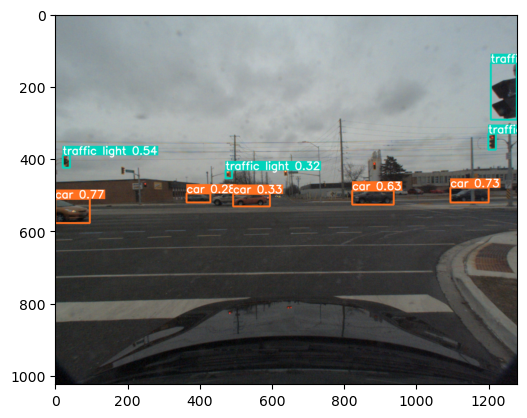

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
image_path = r"runs\detect\predict3\0000000000.png"
image = plt.imread(image_path)
plt.imshow(image)
plt.show()

###### Load Pretrained YOLOv8 Model

In [83]:
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

metrics = model.val(data='data.yaml')
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.0.225 🚀 Python-3.11.4 torch-2.1.1+cpu CPU (Intel Core(TM) i7-7600U 2.80GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning C:\Users\rafae\Documents\Capstone\datasets\valid\labels.cache... 151 images, 22 backgrounds, 0 corrupt: 100%|██████████| 151/151 [00:00<?, ?it/s]

val: WARNING ⚠️ C:\Users\rafae\Documents\Capstone\datasets\valid\images\0000000049_png.rf.8157e62541867cfddc95052fb9821c9b.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\rafae\Documents\Capstone\datasets\valid\images\0000000052_png.rf.eb8d033c5b48f90d491a8735c950bba8.jpg: 2 duplicate labels removed
val: WARNING ⚠️ C:\Users\rafae\Documents\Capstone\datasets\valid\images\0000000055_png.rf.e4fede090167b30611cdf5a834605237.jpg: 3 duplicate labels removed
val: WARNING ⚠️ C:\Users\rafae\Documents\Capstone\datasets\valid\images\0000000150_png.rf.288bfe7b4fce1d6ff4b7e035b7211f0c.jpg: 1 duplicate labels removed
val: WARNING ⚠️ C:\Users\rafae\Documents\Capstone\datasets\valid\images\0000000152_png.rf.906c1bb6d6c147ffb4a74ddfc6e68200.jpg: 2 duplicate labels removed
val: WARNING ⚠️ C:\Users\rafae\Documents\Capstone\datasets\valid\images\0000000154_png.rf.32087b0c75d6126b71a948830e191a3a.jpg: 2 duplicate labels removed
val: WARNING ⚠️ C:\Users\rafae\Documents\Capstone\datasets\valid\image


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:24<00:00,  8.44s/it]

                   all        151        546          0          0          0          0


Speed: 8.0ms preprocess, 515.5ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to runs\detect\val2


array([], dtype=float64)

**Evaluation Metrics:**

**Images:** Total number of images in the evaluation set.

**Instances:** Total number of instances (objects) across all images.

**Box(P):** Precision of the bounding boxes. It's showing 0 in this case.

**R:** Recall, indicating the fraction of relevant instances that have been retrieved over the total amount of relevant instances. It's showing 0 in this case.

**mAP50:** Mean Average Precision at an IoU (Intersection over Union) threshold of 0.5. It's showing 0, which means that at this IoU threshold, the model did not achieve any average precision.

**mAP50-95:** Mean Average Precision over the IoU range from 0.5 to 0.95. It's showing 0 as well.

In summary, the output is suggesting that, for the specified class ("all"), the model's performance in terms of precision, recall, and average precision is currently reported as 0. This might indicate that the model is not performing well on the specified class based on the evaluation metrics used. Improving these metrics would typically involve further model training, tuning, or adjusting parameters.

## Experiment with Faster RCNN 
#### (*In Progress*)

The pretrained Faster RCNN was also trained on COCO dataset.

Here we'll be using the simplest Faster RCNN to set as a benchmark. Then if choose to work with this model we can experiment with different backbones such as MobileNet, ResNet, etc to find the one that best suits your object detection task.

In [90]:
from roboflow import Roboflow

rf = Roboflow(api_key="IvxuC5AtkVBPx3o8pcGV")
project = rf.workspace("machine-learning-engineer-bootcamp").project("adverse-weather-object-detection-10pus")
dataset = project.version(1).download("tfrecord")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Adverse-Weather-Object-Detection-1 in tfrecord:: 100%|██████████| 11/11 [00:00<00:00, 149.05it/s]


Next, we'll implement the Fast RCNN and evaluate it's performance on our dataset and benchmark. 

For that we'll follow the steps on https://pseudo-lab.github.io/Tutorial-Book-en/chapters/en/object-detection/Ch5-Faster-R-CNN.html.

## References

https://medium.com/@beyzaakyildiz/what-is-yolov8-how-to-use-it-b3807d13c5ce


https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3

-https://github.com/chenyuntc/simple-faster-rcnn-pytorch/blob/master/model/faster_rcnn_vgg16.py
    
Faster RCNN pretrained on COCO dataset: https://github.com/trian-ctrn/IntrotoCS_2023/blob/master/Faster_RCNN/IntroToCS_Faster_RCNN.ipynb